In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

In [3]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [4]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
num_particles = 1000
num_turns = 6000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
sweep_per_turn = sweep / num_turns
nemitt_x = 2e-6
nemitt_y = 2e-6

In [6]:
env = line.env
monitor1 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

env.elements['monitor_qd31110'] = monitor1
env.elements['monitor_qf31010'] = monitor2
env.elements['monitor_start'] = monitor3
line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])
# line.insert([env.place('monitor_start', at=0)])
tw = line.twiss()
tt = line.get_table()

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [7]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2320217992352433m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 3.6589e-03
... distance to target bunch length: 3.5107e-03
... distance to target bunch length: -4.3174e-03
... distance to target bunch length: 1.3682e-03
... distance to target bunch length: -2.7445e-04
... distance to target bunch length: 4.0122e-05
... distance to target bunch length: 1.0155e-06
... distance to target bunch length: -1.0755e-10
... distance to target bunch length: 8.3900e-08
--> Bunch length: 0.22399999989244604
--> Emittance: 0.34429845028021805


In [8]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.track(part, num_turns=num_turns, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Found multiple cavities with different frequencies:
200264500.0Hz  at 4500000.0V: ['actcsg.31774' 'actcsj.31958' 'actcsj.31952' 'actcsi.31895'
 'actcsi.31878' 'actcsi.31872' 'actcsh.31854' 'actcsh.31838'
 'actcsh.31832' 'actcsg.31780' 'actcsj.31991' 'actcsg.31758'
 'actcsg.31751' 'actcsf.31695' 'actcsf.31678' 'actcsf.31672'
 'actcse.31654' 'actcse.31637' 'actcse.31632' 'actcsj.31974']
801058000.0Hz  at 500000.0V: ['acl.31936' 'acl.31735']
The sweep will be performed with respect to the highest voltage cavity at 200264500.0Hz. The other cavities will be shifted accordingly.


Slicing line:   0%|          | 0/3851 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 200264501.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.782e-06 per turn.
The bucket height is 0.003647, so this implies the sweep will shift one bucket every 2621.96 turns.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

# Initial distribution

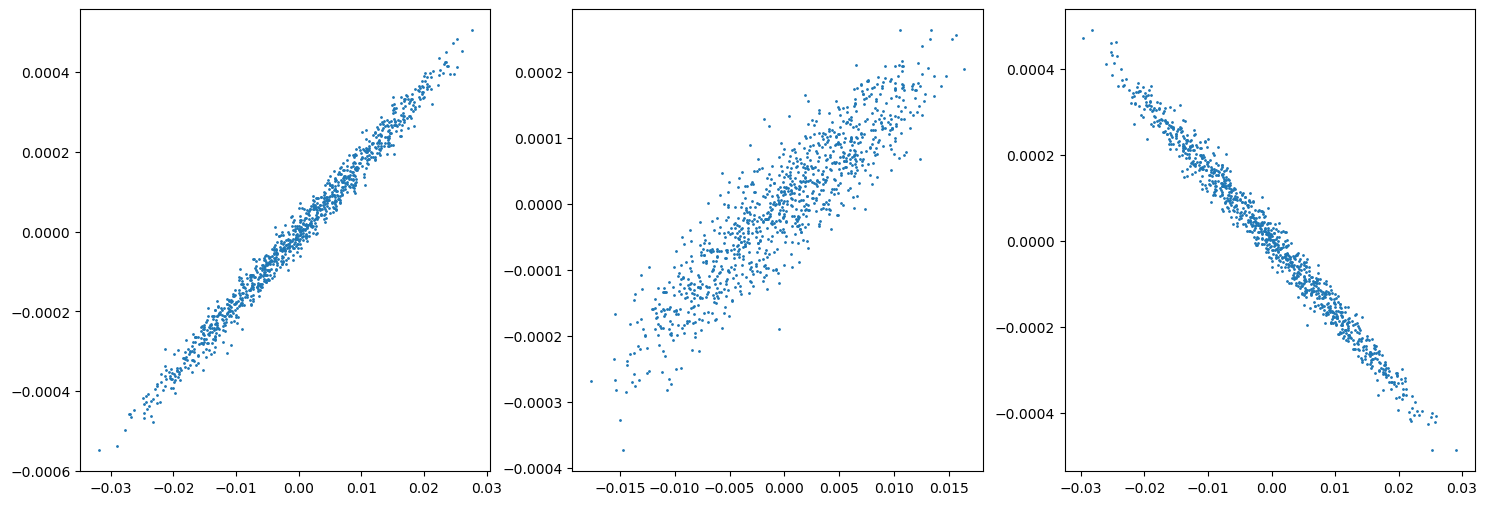

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].scatter(monitor3.x[:,0], monitor3.px[:,0], s=1)
ax[1].scatter(monitor1.x[:,0], monitor1.px[:,0], s=1)
ax[2].scatter(monitor2.x[:,0], monitor2.px[:,0], s=1)

# Evolution of specific particles

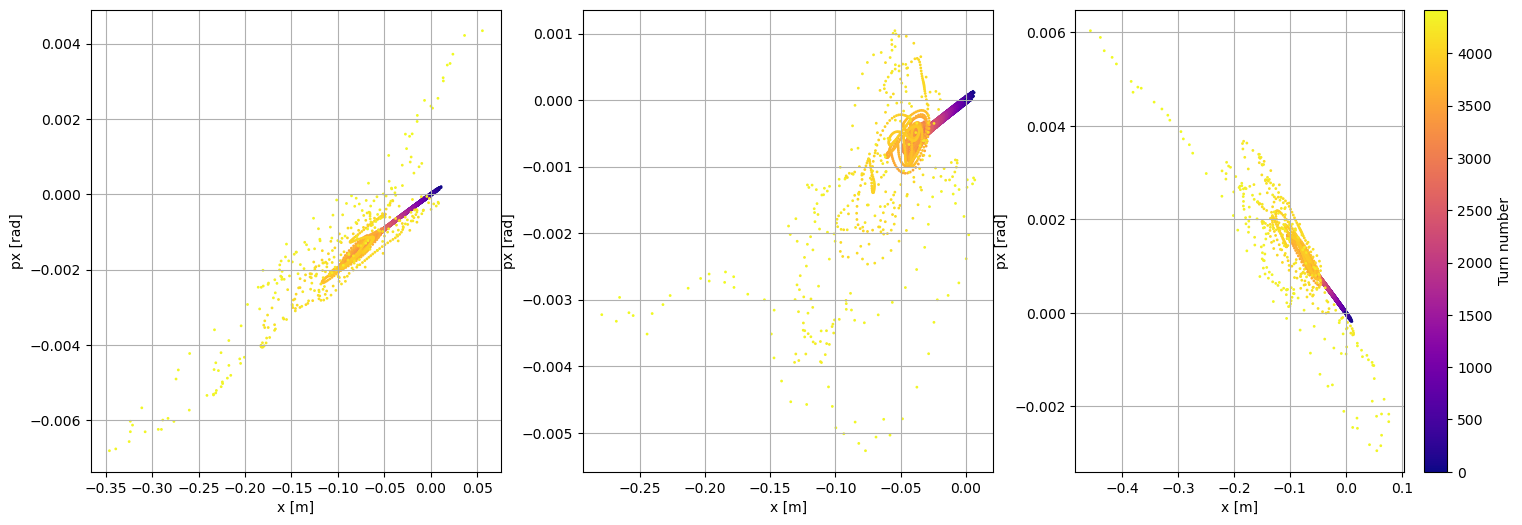

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].scatter(monitor3.x[0,:], monitor3.px[0,:], s=1, c=monitor3.at_turn[0,:], cmap='plasma')
ax[1].scatter(monitor1.x[0,:], monitor1.px[0,:], s=1, c=monitor1.at_turn[0,:], cmap='plasma')
sc = ax[2].scatter(monitor2.x[0,:], monitor2.px[0,:], s=1, c=monitor2.at_turn[0,:], cmap='plasma')

for axis in ax:
    axis.set_xlabel('x [m]')
    axis.set_ylabel('px [rad]')
    axis.grid()
fig.colorbar(sc, ax=ax[2], label='Turn number')

# State and turn

(0.0, 10.0)

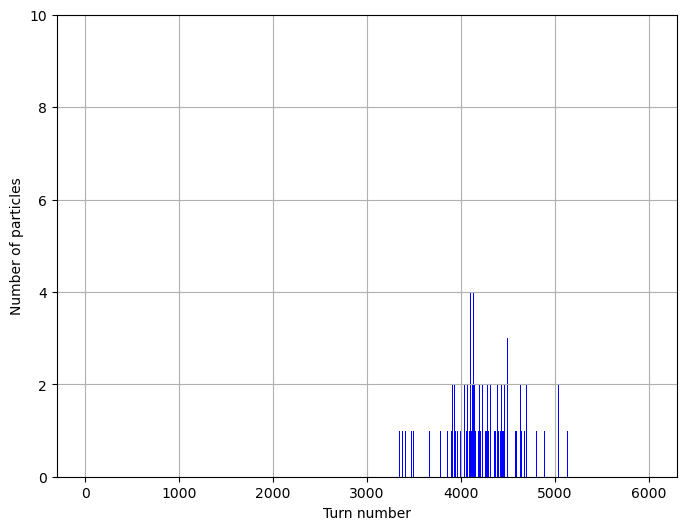

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.hist(part.at_turn, bins=num_turns, range=(0, num_turns), color='blue')
ax.set_xlabel('Turn number')
ax.set_ylabel('Number of particles')
ax.grid()
ax.set_ylim(0,10)

# Particle distribution evolution

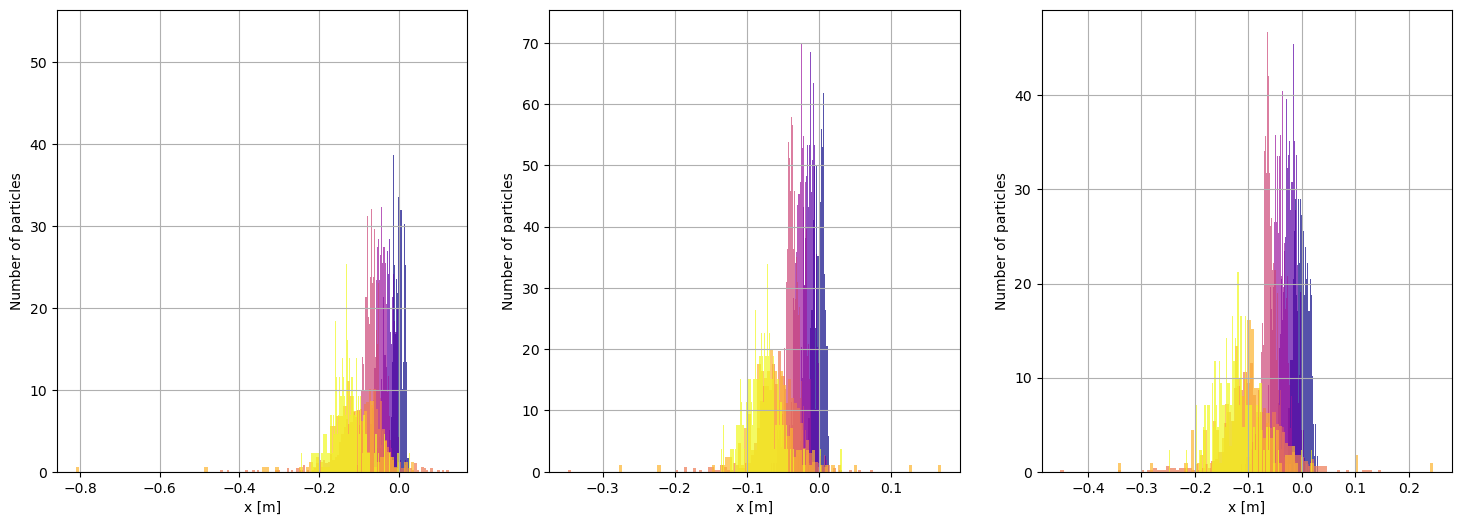

In [117]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

cmap = plt.get_cmap('plasma')

for turn in [0, 1000, 2000, 3000, 4000, 5000, 5999]:
    ax[0].hist(monitor3.x[:,turn][monitor3.state[:,turn]>0], bins=100, histtype='stepfilled', density=True, color=cmap(turn/6000), alpha=0.7)
    ax[1].hist(monitor1.x[:,turn][monitor1.state[:,turn]>0], bins=100, histtype='stepfilled', density=True, color=cmap(turn/6000), alpha=0.7)
    ax[2].hist(monitor2.x[:,turn][monitor2.state[:,turn]>0], bins=100, histtype='stepfilled', density=True, color=cmap(turn/6000), alpha=0.7)

for axis in ax:
    axis.set_xlabel('x [m]')
    axis.set_ylabel('Number of particles')
    axis.grid()

# Mean and std evolution

In [10]:
means = {'monitor3': [], 'monitor1': [], 'monitor2': []}
stds = {'monitor3': [], 'monitor1': [], 'monitor2': []}

for turn in range(num_turns):
    means['monitor3'].append(np.mean(monitor3.x[:,turn][monitor3.state[:,turn]>0]))
    stds['monitor3'].append(np.std(monitor3.x[:,turn][monitor3.state[:,turn]>0]))
    means['monitor1'].append(np.mean(monitor1.x[:,turn][monitor1.state[:,turn]>0]))
    stds['monitor1'].append(np.std(monitor1.x[:,turn][monitor1.state[:,turn]>0]))
    means['monitor2'].append(np.mean(monitor2.x[:,turn][monitor2.state[:,turn]>0]))
    stds['monitor2'].append(np.std(monitor2.x[:,turn][monitor2.state[:,turn]>0]))

for m in means:
    means[m] = np.array(means[m])
    stds[m] = np.array(stds[m])

In [119]:
np.min(part.at_turn)

np.int64(3179)

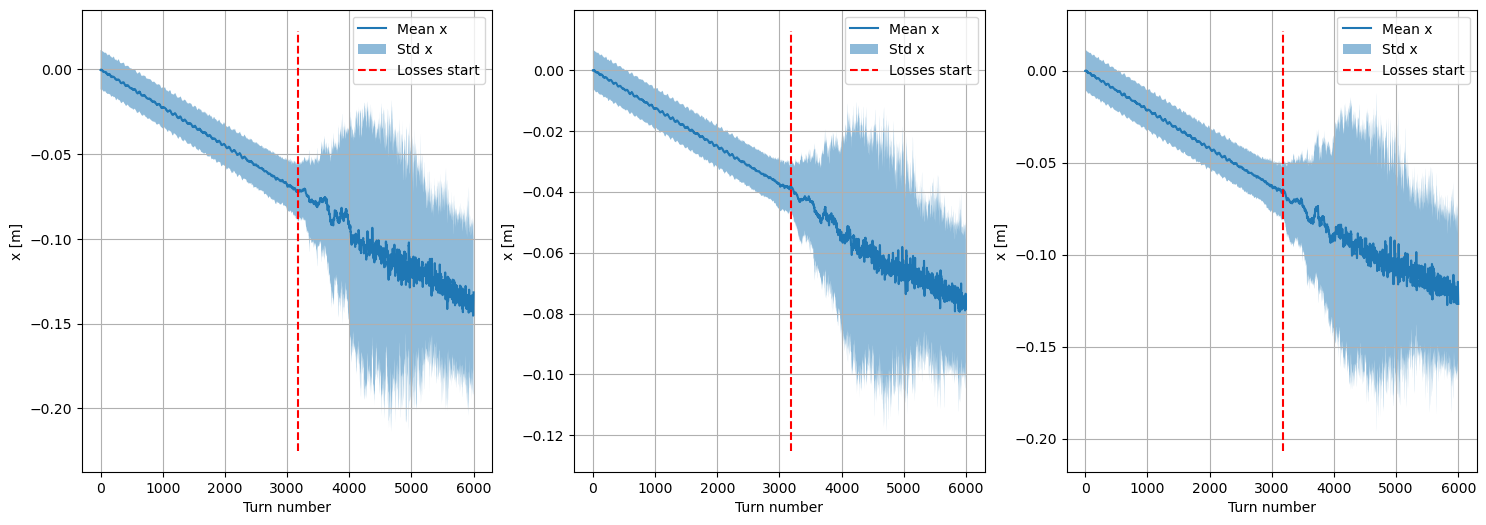

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(means['monitor3'], label='Mean x')
ax[0].fill_between(np.arange(num_turns), means['monitor3'] - stds['monitor3'], means['monitor3'] + stds['monitor3'], alpha=0.5, label='Std x')
ax[1].plot(means['monitor1'], label='Mean x')
ax[1].fill_between(np.arange(num_turns), means['monitor1'] - stds['monitor1'], means['monitor1'] + stds['monitor1'], alpha=0.5, label='Std x')
ax[2].plot(means['monitor2'], label='Mean x')
ax[2].fill_between(np.arange(num_turns), means['monitor2'] - stds['monitor2'], means['monitor2'] + stds['monitor2'], alpha=0.5, label='Std x')

for axis in ax:
    axis.vlines(np.min(part.at_turn),ymin=axis.get_ylim()[0], ymax=axis.get_ylim()[1], colors='red', linestyles='dashed', label='Losses start')
    axis.set_xlabel('Turn number')
    axis.set_ylabel('x [m]')
    axis.grid()
    axis.legend()

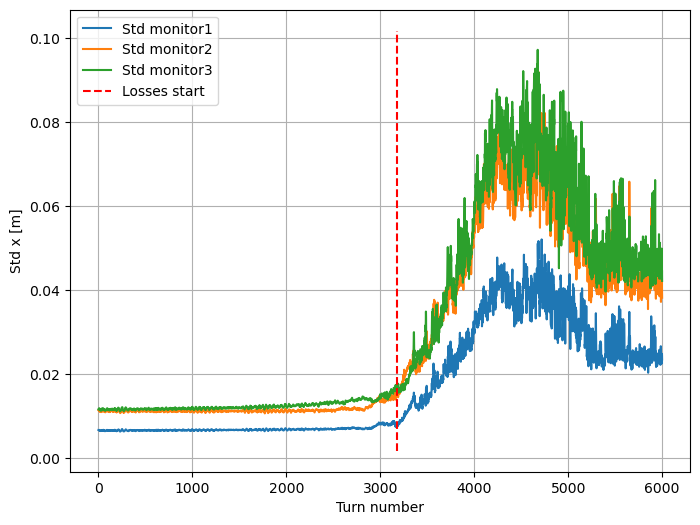

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(stds['monitor1'], label='Std monitor1')
ax.plot(stds['monitor2'], label='Std monitor2')
ax.plot(stds['monitor3'], label='Std monitor3')

ax.vlines(np.min(part.at_turn),ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='red', linestyles='dashed', label='Losses start')
ax.legend()
ax.set_xlabel('Turn number')
ax.set_ylabel('Std x [m]')
ax.grid()

Sweeping increases the std so distribution spread. Could be just dispersion effect, so we can check by subtracting dispersion in that position

In [12]:
means2 = {'monitor3': [], 'monitor1': [], 'monitor2': []}
stds2 = {'monitor3': [], 'monitor1': [], 'monitor2': []}

for turn in range(num_turns):
    means2['monitor3'].append(np.mean(monitor3.x[:,turn][monitor3.state[:,turn]>0] - tw.rows['monitor_start'].dx[0] * monitor3.delta[:,turn][monitor3.state[:,turn]>0]))
    stds2['monitor3'].append(np.std(monitor3.x[:,turn][monitor3.state[:,turn]>0] - tw.rows['monitor_start'].dx[0] * monitor3.delta[:,turn][monitor3.state[:,turn]>0]))
    means2['monitor1'].append(np.mean(monitor1.x[:,turn][monitor1.state[:,turn]>0] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[:,turn][monitor1.state[:,turn]>0]))
    stds2['monitor1'].append(np.std(monitor1.x[:,turn][monitor1.state[:,turn]>0] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[:,turn][monitor1.state[:,turn]>0]))
    means2['monitor2'].append(np.mean(monitor2.x[:,turn][monitor2.state[:,turn]>0] - tw.rows['monitor_qf31010'].dx[0] * monitor2.delta[:,turn][monitor2.state[:,turn]>0]))
    stds2['monitor2'].append(np.std(monitor2.x[:,turn][monitor2.state[:,turn]>0] - tw.rows['monitor_qf31010'].dx[0] * monitor2.delta[:,turn][monitor2.state[:,turn]>0]))

for m in means2:
    means2[m] = np.array(means[m])
    stds2[m] = np.array(stds[m])

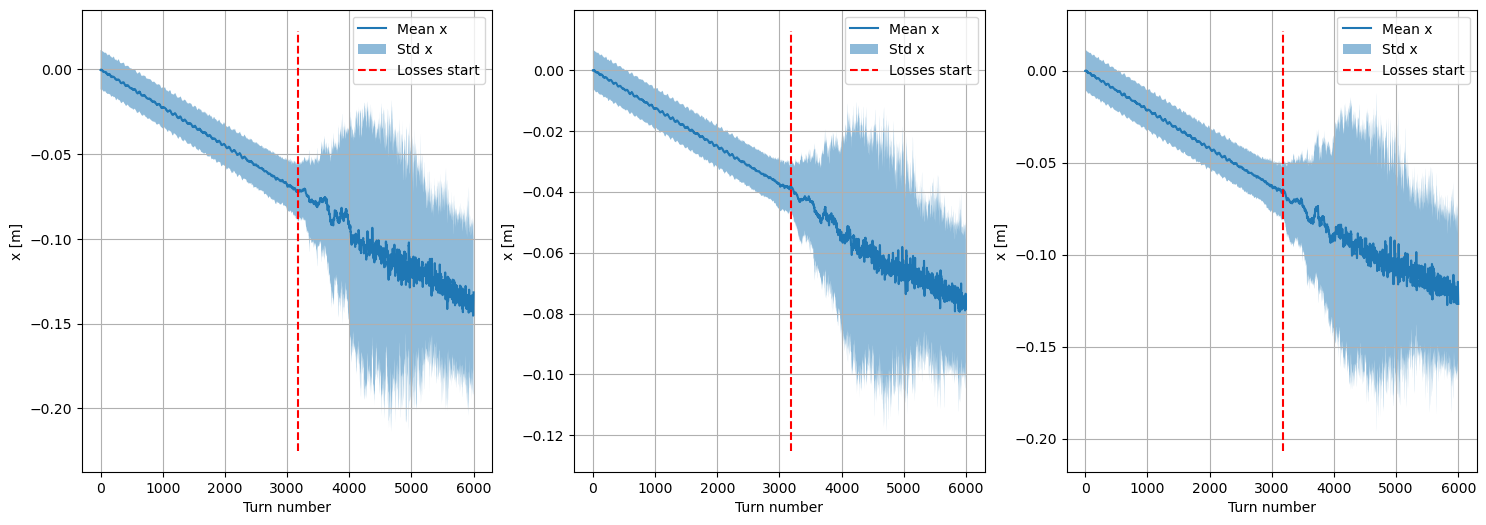

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(means2['monitor3'], label='Mean x')
ax[0].fill_between(np.arange(num_turns), means2['monitor3'] - stds2['monitor3'], means2['monitor3'] + stds2['monitor3'], alpha=0.5, label='Std x')
ax[1].plot(means2['monitor1'], label='Mean x')
ax[1].fill_between(np.arange(num_turns), means2['monitor1'] - stds2['monitor1'], means2['monitor1'] + stds2['monitor1'], alpha=0.5, label='Std x')
ax[2].plot(means2['monitor2'], label='Mean x')
ax[2].fill_between(np.arange(num_turns), means2['monitor2'] - stds2['monitor2'], means2['monitor2'] + stds2['monitor2'], alpha=0.5, label='Std x')

for axis in ax:
    axis.vlines(np.min(part.at_turn),ymin=axis.get_ylim()[0], ymax=axis.get_ylim()[1], colors='red', linestyles='dashed', label='Losses start')
    axis.set_xlabel('Turn number')
    axis.set_ylabel('x [m]')
    axis.grid()
    axis.legend()

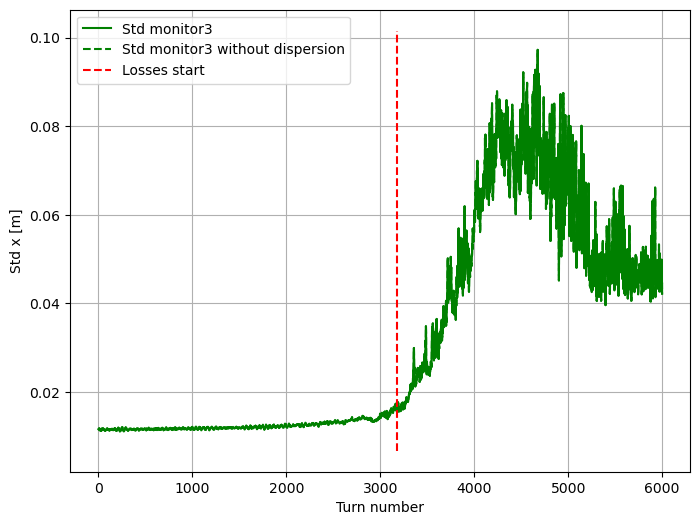

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#ax.plot(stds['monitor1'], label='Std monitor1', c='blue')
#ax.plot(stds['monitor2'], label='Std monitor2', c='orange')
ax.plot(stds['monitor3'], label='Std monitor3', c='green')
#ax.plot(stds2['monitor1'], ls = '--', label='Std monitor1 without dispersion', c='blue')
#ax.plot(stds2['monitor2'], ls = '--', label='Std monitor2 without dispersion', c='orange')
ax.plot(stds2['monitor3'], ls = '--', label='Std monitor3 without dispersion', c='green')
ax.vlines(np.min(part.at_turn),ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='red', linestyles='dashed', label='Losses start')
ax.legend()
# ax.set_xlim(0,3000)
ax.set_xlabel('Turn number')
ax.set_ylabel('Std x [m]')
ax.grid()

In [138]:
turn =0
print(np.mean(tw.rows['monitor_start'].dx[0] * monitor3.delta[:,turn][monitor3.state[:,turn]>0]))
print(np.mean(monitor3.x[:,turn][monitor3.state[:,turn]>0]))

-0.0001865019220490885
-0.00029180856995958415


In [136]:
np.mean(monitor3.x[:,turn][monitor3.state[:,turn]>0])

np.float64(-0.1315977336023581)

In [21]:
tw.rows['monitor.*'].dx

array([7.97140198, 7.69525349, 4.51364348])

In [38]:
%matplotlib tk
# plt.plot(monitor3.x[0], monitor3.delta[0])
# plt.plot(monitor3.x[0] - 7.9714*monitor3.delta[0], monitor3.delta[0])
plt.plot(monitor3.x[0][3000:], monitor3.px[0][3000:])
plt.plot(monitor3.x[0][3000:] - 7.9714*monitor3.delta[0][3000:], monitor3.px[0][3000:])

In [1]:
# plt.plot(monitor3.x.mean(axis=0))
# plt.plot((monitor3.x - tw.rows['monitor_start'].dx[0]*monitor3.delta).mean(axis=0))

# plt.plot(monitor1.x.mean(axis=0))
# plt.plot((monitor1.x - tw.rows['monitor_qd31110'].dx[0]*monitor1.delta).mean(axis=0))

plt.plot(monitor2.x.mean(axis=0))
plt.plot((monitor2.x - tw.rows['monitor_qf31010'].dx[0]*monitor2.delta).mean(axis=0))

NameError: name 'plt' is not defined

In [11]:
means3 = {'monitor3': [], 'monitor1': [], 'monitor2': []}
stds3 = {'monitor3': [], 'monitor1': [], 'monitor2': []}

for turn in range(num_turns):
    means3['monitor3'].append(np.mean(monitor3.x[:,turn][monitor3.state[:,turn]>0] - tw.rows['monitor_start'].dx[0] * monitor3.delta[:,turn][monitor3.state[:,turn]>0] - 1/2 * tw.rows['monitor_start'].ddx[0] * (monitor3.delta[:,turn][monitor3.state[:,turn]>0])**2))
    stds3['monitor3'].append(np.std(monitor3.x[:,turn][monitor3.state[:,turn]>0] - tw.rows['monitor_start'].dx[0] * monitor3.delta[:,turn][monitor3.state[:,turn]>0] - 1/2 * tw.rows['monitor_start'].ddx[0] * (monitor3.delta[:,turn][monitor3.state[:,turn]>0])**2))
    means3['monitor1'].append(np.mean(monitor1.x[:,turn][monitor1.state[:,turn]>0] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[:,turn][monitor1.state[:,turn]>0]) - 1/2 * tw.rows['monitor_qd31110'].ddx[0] * (monitor1.delta[:,turn][monitor1.state[:,turn]>0])**2)
    stds3['monitor1'].append(np.std(monitor1.x[:,turn][monitor1.state[:,turn]>0] - tw.rows['monitor_qd31110'].dx[0] * monitor1.delta[:,turn][monitor1.state[:,turn]>0]) - 1/2 * tw.rows['monitor_qd31110'].ddx[0] * (monitor1.delta[:,turn][monitor1.state[:,turn]>0])**2)
    means3['monitor2'].append(np.mean(monitor2.x[:,turn][monitor2.state[:,turn]>0] - tw.rows['monitor_qf31010'].dx[0] * monitor2.delta[:,turn][monitor2.state[:,turn]>0]) - 1/2 * tw.rows['monitor_qf31010'].ddx[0] * (monitor2.delta[:,turn][monitor2.state[:,turn]>0])**2)
    stds3['monitor2'].append(np.std(monitor2.x[:,turn][monitor2.state[:,turn]>0] - tw.rows['monitor_qf31010'].dx[0] * monitor2.delta[:,turn][monitor2.state[:,turn]>0]) - 1/2 * tw.rows['monitor_qf31010'].ddx[0] * (monitor2.delta[:,turn][monitor2.state[:,turn]>0])**2)

for m in means3:
    means3[m] = np.array(means[m])
    stds3[m] = np.array(stds[m])

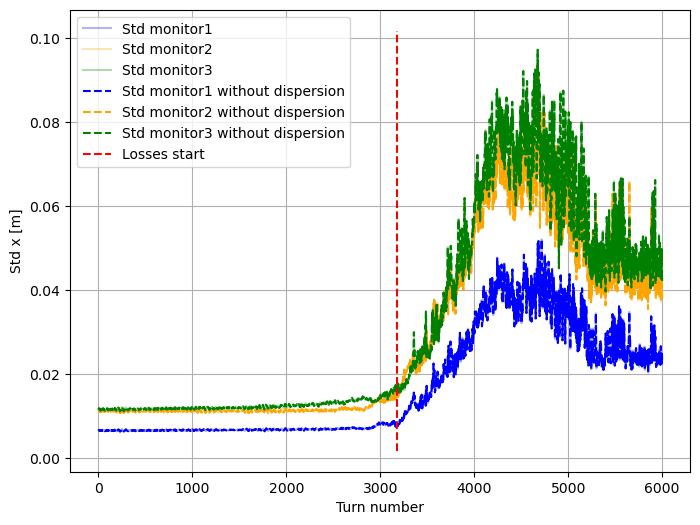

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(stds['monitor1'], alpha=0.3, label='Std monitor1', c='blue')
ax.plot(stds['monitor2'], alpha=0.3,label='Std monitor2', c='orange')
ax.plot(stds['monitor3'], alpha=0.3, label='Std monitor3', c='green')
ax.plot(stds3['monitor1'], ls = '--', label='Std monitor1 without dispersion', c='blue')
ax.plot(stds3['monitor2'], ls = '--', label='Std monitor2 without dispersion', c='orange')
ax.plot(stds3['monitor3'], ls = '--', label='Std monitor3 without dispersion', c='green')
ax.vlines(np.min(part.at_turn),ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='red', linestyles='dashed', label='Losses start')
ax.legend()
# ax.set_xlim(0,3000)
# ax.set_ylim(0,0.02)
ax.set_xlabel('Turn number')
ax.set_ylabel('Std x [m]')
ax.grid()

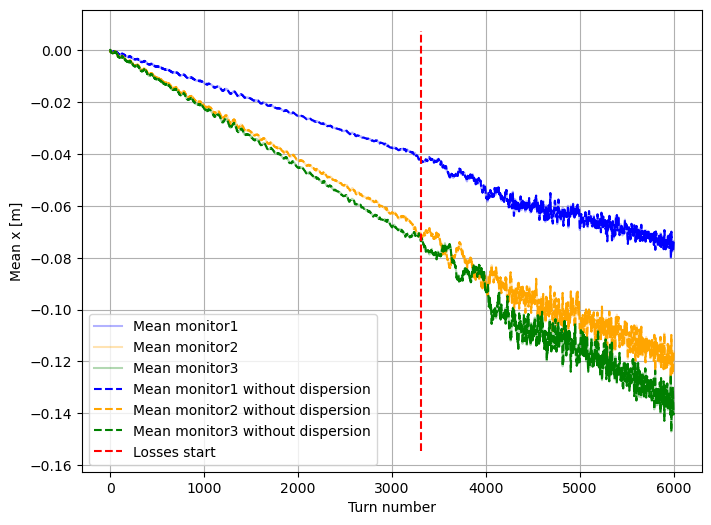

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(means['monitor1'], alpha=0.3, label='Mean monitor1', c='blue')
ax.plot(means['monitor2'], alpha=0.3, label='Mean monitor2', c='orange')
ax.plot(means['monitor3'], alpha=0.3, label='Mean monitor3', c='green')
ax.plot(means3['monitor1'], ls = '--', label='Mean monitor1 without dispersion', c='blue')
ax.plot(means3['monitor2'], ls = '--', label='Mean monitor2 without dispersion', c='orange')
ax.plot(means3['monitor3'], ls = '--', label='Mean monitor3 without dispersion', c='green')
ax.vlines(np.min(part.at_turn),ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='red', linestyles='dashed', label='Losses start')
ax.legend()
# ax.set_xlim(0,3000)
# ax.set_ylim(0,0.02)
ax.set_xlabel('Turn number')
ax.set_ylabel('Mean x [m]')
ax.grid()

In [143]:
tw.ddx

array([-44.394033  , -44.394033  , -44.394033  , ..., -44.15889016,
       -44.39443465, -44.39443465], shape=(3852,))

In [148]:
print(np.mean(tw.rows['monitor_start'].dx[0] * monitor3.delta[:,turn][monitor3.state[:,turn]>0]))
print(np.mean(monitor3.x[:,turn][monitor3.state[:,turn]>0]))

-0.12455386216925271
-0.1315977336023581


# Frederik correction

In [ ]:
# plt.plot(monitor3.x.mean(axis=0))
# plt.plot((monitor3.x - tw.rows['monitor_start'].dx[0]*monitor3.delta).mean(axis=0))

# plt.plot(monitor1.x.mean(axis=0))
# plt.plot((monitor1.x - tw.rows['monitor_qd31110'].dx[0]*monitor1.delta).mean(axis=0))

plt.plot(monitor2.x.mean(axis=0))
plt.plot((monitor2.x - tw.rows['monitor_qf31010'].dx[0]*monitor2.delta).mean(axis=0))

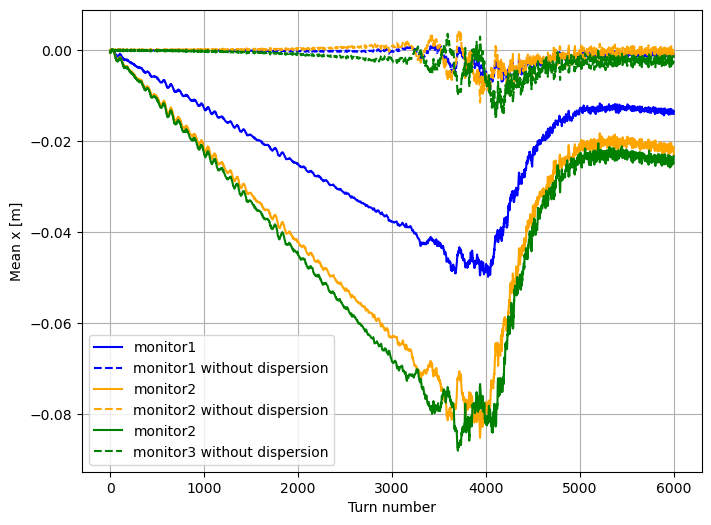

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(monitor1.x.mean(axis=0), color='blue', label = 'monitor1')
ax.plot((monitor1.x - tw.rows['monitor_qd31110'].dx[0]*monitor1.delta).mean(axis=0), ls = '--', color='blue', label = 'monitor1 without dispersion')
ax.plot(monitor2.x.mean(axis=0), color='orange', label = 'monitor2')
ax.plot((monitor2.x - tw.rows['monitor_qf31010'].dx[0]*monitor2.delta).mean(axis=0), ls = '--', color='orange', label = 'monitor2 without dispersion')
plt.plot(monitor3.x.mean(axis=0), color='green', label = 'monitor2')
plt.plot((monitor3.x - tw.rows['monitor_start'].dx[0]*monitor3.delta).mean(axis=0), ls = '--', color='green', label = 'monitor3 without dispersion')
ax.grid()
ax.set_xlabel('Turn number')
ax.set_ylabel('Mean x [m]')
ax.legend()